### 
> - **To sell more credit card products to Bank customers**
> -
> - To identify the potential customers who have a higher probability of purchasing the card so that     we can recommend that particular card to user.

In [1]:
import numpy as np # 
import pandas as pd # 


import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from datetime import datetime
from datetime import date

In [2]:
import os
print(os.listdir())

['.ipynb_checkpoints', 'banking recommendation model-Classification of credit card(Recommendation)-Copy2.ipynb', 'banking recommendation model-Classification of credit card(Recommendation).ipynb', 'banking recommendation model-Segmentation.ipynb', 'Banking use case', 'bank_rec_day1.ipynb', 'bank_rec_day2.ipynb', 'bank_rec_day3-Copy2.ipynb', 'bank_rec_day3.ipynb', 'bank_rec_EDA_Graph_final.ipynb', 'completedacct.csv', 'completedcard.csv', 'completedclient.csv', 'completeddisposition.csv', 'completeddistrict.csv', 'completedloan.csv', 'completedorder.csv', 'completedtrans.csv', 'CRM Call Center Logs.csv', 'CRM Events.csv', 'CRM Events.xlsx', 'CRM Reviews.csv', 'CRM Reviews.xlsx', 'lgbm_importances-01.png', 'LuxuryLoanPortfolio.csv']


In [3]:
accounts_df = pd.read_csv ('completedacct.csv', sep = ',')
cards_df = pd.read_csv ('completedcard.csv', sep = ',')
clients_df = pd.read_csv ('completedclient.csv', sep = ',')
dispos_df = pd.read_csv ('completeddisposition.csv', sep = ',')
district_df = pd.read_csv ('completeddistrict.csv', sep = ',')
loan_df = pd.read_csv ('completedloan.csv', sep = ',')
order_df = pd.read_csv ('completedorder.csv', sep = ',')
trans_df = pd.read_csv ('completedtrans.csv', sep = ',')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
trans_df ['operation'].fillna ('INTEREST_CREDIT', inplace = True)

In [165]:
trans_df.head()

,Unnamed: 0,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,pos_sum,neg_sum
0,1,T00695247,A00002378,Credit,Credit in Cash,700.0,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40,700.0,NaN
1,2,T00171812,A00000576,Credit,Credit in Cash,900.0,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33,900.0,NaN
2,3,T00207264,A00000704,Credit,Credit in Cash,1000.0,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21,1000.0,NaN
3,4,T01117247,A00003818,Credit,Credit in Cash,600.0,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35,600.0,NaN
4,5,T00579373,A00001972,Credit,Credit in Cash,400.0,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25,400.0,NaN


## Creating features & calculating credit and debit balance from each account id

In [5]:
f = lambda x: -x

In [6]:
#columns with amounts that affects balance positively - collection from another banks 
trans_df = trans_df.assign (pos_sum = np.nan)

#columns with amounts that affects balance negatively - remittance to another banks
trans_df = trans_df.assign (neg_sum = np.nan)

#filling columns pos_sum and neg_sum based on operation type. pos_sum stands for inflows
trans_df.pos_sum = trans_df.amount.where (trans_df.type == 'Credit', trans_df.pos_sum)

#neg_sum stands for outflows
trans_df.neg_sum = trans_df.amount.where (trans_df.type == 'Debit', trans_df.neg_sum )

In [7]:
trans_df['neg_sum']=trans_df['neg_sum'].apply(f)
dummy_trans_df= trans_df[['account_id', 'type', 'fulldate','pos_sum', 'neg_sum']]

In [8]:
dummy_trans_cr_db_df=dummy_trans_df.groupby(['account_id', 'type']).sum() \
  .groupby(level=0).cumsum().reset_index()
dummy_trans_db_df =dummy_trans_cr_db_df[dummy_trans_cr_db_df.type=='Debit']

In [9]:
dummy_trans_db_df.head(3)

,account_id,type,pos_sum,neg_sum
1,A00000001,Debit,194320.5,-180854.0
3,A00000002,Debit,1597053.5,-1554425.8
5,A00000003,Debit,173059.0,-121962.8


#### Creating dummies of operation performed by each Account to merge in tans_df 

In [10]:
df_dummy=trans_df[['account_id','operation']]
df_dummy.drop_duplicates(inplace=True) 
df_dummy=df_dummy.reset_index(drop=True)

Trans_operat_df_dummy=pd.get_dummies(df_dummy, columns=["operation"]).groupby(['account_id'], as_index=False).sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
Trans_operat_df_dummy.head()

,account_id,operation_Cash Withdrawal,operation_Collection from Another Bank,operation_Credit Card Withdrawal,operation_Credit in Cash,operation_INTEREST_CREDIT,operation_Remittance to Another Bank
0,A00000001,1,1,0,1,1,1
1,A00000002,1,1,0,1,1,1
2,A00000003,1,0,0,1,1,1
3,A00000004,1,1,0,1,1,1
4,A00000005,1,1,0,1,1,1


### MERGE 1
1. dummy_trans_db_df + Trans_operat_df_dummy

In [12]:

Trans_merged_df = dummy_trans_db_df.merge (Trans_operat_df_dummy, left_on = 'account_id', right_on = 'account_id', 
                                           how = 'left', validate = 'one_to_one') 
display (dummy_trans_db_df.head (n=3))
display (Trans_merged_df.head (n=3))     
print ("Verifying shape. Before: " + str (dummy_trans_db_df.shape)+ " After: " + str (Trans_merged_df.shape))

,account_id,type,pos_sum,neg_sum
1,A00000001,Debit,194320.5,-180854.0
3,A00000002,Debit,1597053.5,-1554425.8
5,A00000003,Debit,173059.0,-121962.8


,account_id,type,pos_sum,neg_sum,operation_Cash Withdrawal,operation_Collection from Another Bank,operation_Credit Card Withdrawal,operation_Credit in Cash,operation_INTEREST_CREDIT,operation_Remittance to Another Bank
0,A00000001,Debit,194320.5,-180854.0,1,1,0,1,1,1
1,A00000002,Debit,1597053.5,-1554425.8,1,1,0,1,1,1
2,A00000003,Debit,173059.0,-121962.8,1,0,0,1,1,1


Verifying shape. Before: (4500, 4) After: (4500, 10)


### MERGE 2
1. Merge1 + accounts_df

In [13]:

#merging cards_df and corresponding dispos_df so to find client_id and then from client_id to find corresponding region data

trans_accnt_df = Trans_merged_df.merge (accounts_df, left_on = 'account_id', right_on = 'account_id', 
                                           how = 'left', validate = 'one_to_one') 
display (Trans_merged_df.head (n=3))
display (trans_accnt_df.head (n=3))     
print ("Verifying shape. Before: " + str (Trans_merged_df.shape)+ " After: " + str (trans_accnt_df.shape))

,account_id,type,pos_sum,neg_sum,operation_Cash Withdrawal,operation_Collection from Another Bank,operation_Credit Card Withdrawal,operation_Credit in Cash,operation_INTEREST_CREDIT,operation_Remittance to Another Bank
0,A00000001,Debit,194320.5,-180854.0,1,1,0,1,1,1
1,A00000002,Debit,1597053.5,-1554425.8,1,1,0,1,1,1
2,A00000003,Debit,173059.0,-121962.8,1,0,0,1,1,1


,account_id,type,pos_sum,neg_sum,operation_Cash Withdrawal,operation_Collection from Another Bank,operation_Credit Card Withdrawal,operation_Credit in Cash,operation_INTEREST_CREDIT,operation_Remittance to Another Bank,district_id,frequency,parseddate,year,month,day
0,A00000001,Debit,194320.5,-180854.0,1,1,0,1,1,1,18,Monthly Issuance,2015-03-24,2015,3,24
1,A00000002,Debit,1597053.5,-1554425.8,1,1,0,1,1,1,1,Monthly Issuance,2013-02-26,2013,2,26
2,A00000003,Debit,173059.0,-121962.8,1,0,0,1,1,1,5,Monthly Issuance,2017-07-07,2017,7,7


Verifying shape. Before: (4500, 10) After: (4500, 16)


### MERGE 3
1. Merge2 + dispos_df

In [14]:
dispos_dummy_df=pd.get_dummies(dispos_df, columns=["type"]).groupby(['client_id','account_id','disp_id'], as_index=False).sum()

In [15]:
#merging cards_df and corresponding dispos_df so to find client_id and then from client_id to find corresponding region data

trans_accnt_dispos_df = trans_accnt_df.merge (dispos_dummy_df, left_on = 'account_id', right_on = 'account_id', 
                                           how = 'left', validate = 'one_to_many') 
display (trans_accnt_df.head (n=3))
display (trans_accnt_dispos_df.head (n=3))     
print ("Verifying shape. Before: " + str (trans_accnt_df.shape)+ " After: " + str (trans_accnt_dispos_df.shape))

,account_id,type,pos_sum,neg_sum,operation_Cash Withdrawal,operation_Collection from Another Bank,operation_Credit Card Withdrawal,operation_Credit in Cash,operation_INTEREST_CREDIT,operation_Remittance to Another Bank,district_id,frequency,parseddate,year,month,day
0,A00000001,Debit,194320.5,-180854.0,1,1,0,1,1,1,18,Monthly Issuance,2015-03-24,2015,3,24
1,A00000002,Debit,1597053.5,-1554425.8,1,1,0,1,1,1,1,Monthly Issuance,2013-02-26,2013,2,26
2,A00000003,Debit,173059.0,-121962.8,1,0,0,1,1,1,5,Monthly Issuance,2017-07-07,2017,7,7


,account_id,type,pos_sum,neg_sum,operation_Cash Withdrawal,operation_Collection from Another Bank,operation_Credit Card Withdrawal,operation_Credit in Cash,operation_INTEREST_CREDIT,operation_Remittance to Another Bank,district_id,frequency,parseddate,year,month,day,client_id,disp_id,type_Owner,type_User
0,A00000001,Debit,194320.5,-180854.0,1,1,0,1,1,1,18,Monthly Issuance,2015-03-24,2015,3,24,C00000001,D00000001,1,0
1,A00000002,Debit,1597053.5,-1554425.8,1,1,0,1,1,1,1,Monthly Issuance,2013-02-26,2013,2,26,C00000002,D00000002,1,0
2,A00000002,Debit,1597053.5,-1554425.8,1,1,0,1,1,1,1,Monthly Issuance,2013-02-26,2013,2,26,C00000003,D00000003,0,1


Verifying shape. Before: (4500, 16) After: (5369, 20)


### Merge 4
merge 3+Cards_df

In [16]:
cards_df =cards_df[['disp_id', 'type']]

In [17]:
trans_accnt_dispos_cards_df = trans_accnt_dispos_df.merge (cards_df, left_on = 'disp_id', right_on = 'disp_id', 
                                           how = 'left', validate = 'many_to_one') 
display (trans_accnt_dispos_df.head (n=3))
display (trans_accnt_dispos_cards_df.head (n=3))     
print ("Verifying shape. Before: " + str (trans_accnt_dispos_df.shape)+ " After: " + str (trans_accnt_dispos_cards_df.shape))

,account_id,type,pos_sum,neg_sum,operation_Cash Withdrawal,operation_Collection from Another Bank,operation_Credit Card Withdrawal,operation_Credit in Cash,operation_INTEREST_CREDIT,operation_Remittance to Another Bank,district_id,frequency,parseddate,year,month,day,client_id,disp_id,type_Owner,type_User
0,A00000001,Debit,194320.5,-180854.0,1,1,0,1,1,1,18,Monthly Issuance,2015-03-24,2015,3,24,C00000001,D00000001,1,0
1,A00000002,Debit,1597053.5,-1554425.8,1,1,0,1,1,1,1,Monthly Issuance,2013-02-26,2013,2,26,C00000002,D00000002,1,0
2,A00000002,Debit,1597053.5,-1554425.8,1,1,0,1,1,1,1,Monthly Issuance,2013-02-26,2013,2,26,C00000003,D00000003,0,1


,account_id,type_x,pos_sum,neg_sum,operation_Cash Withdrawal,operation_Collection from Another Bank,operation_Credit Card Withdrawal,operation_Credit in Cash,operation_INTEREST_CREDIT,operation_Remittance to Another Bank,...,frequency,parseddate,year,month,day,client_id,disp_id,type_Owner,type_User,type_y
0,A00000001,Debit,194320.5,-180854.0,1,1,0,1,1,1,...,Monthly Issuance,2015-03-24,2015,3,24,C00000001,D00000001,1,0,NaN
1,A00000002,Debit,1597053.5,-1554425.8,1,1,0,1,1,1,...,Monthly Issuance,2013-02-26,2013,2,26,C00000002,D00000002,1,0,NaN
2,A00000002,Debit,1597053.5,-1554425.8,1,1,0,1,1,1,...,Monthly Issuance,2013-02-26,2013,2,26,C00000003,D00000003,0,1,NaN


Verifying shape. Before: (5369, 20) After: (5369, 21)


### Merge 5
merge 4+Clients_df

In [18]:
clients_dist_df = clients_df
clients_dist2_df = clients_dist_df.merge (district_df, left_on = 'district_id', right_on = 'district_id', 
                                           how = 'left', validate = 'many_to_one') 
display (clients_df.head (n=3))
display (clients_dist2_df.head (n=3))

,client_id,sex,fulldate,day,month,year,age,social,first,middle,last,phone,email,address_1,address_2,city,state,zipcode,district_id
0,C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18
1,C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,NaN,New York City,NY,10040,1
2,C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,NaN,New York City,NY,10162,1


,client_id,sex,fulldate,day,month,year,age,social,first,middle,...,address_2,city_x,state,zipcode,district_id,city_y,state_name,state_abbrev,region,division
0,C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,...,Unit 1,Albuquerque,NM,47246,18,Albuquerque,New Mexico,NM,West,Mountain
1,C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,...,NaN,New York City,NY,10040,1,New York City,New York,NY,Northeast,Middle Atlantic
2,C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,...,NaN,New York City,NY,10162,1,New York City,New York,NY,Northeast,Middle Atlantic


In [19]:
clients_df_dummy =clients_dist2_df[['client_id', 'sex','age','city_x', 'state', 'zipcode', 'district_id','region','division']]

In [20]:
final_df = clients_df_dummy.merge (trans_accnt_dispos_cards_df, left_on = 'client_id', right_on = 'client_id', 
                                           how = 'left', validate = 'one_to_one') 
display (clients_df_dummy.head (n=3))
display (final_df.head (n=3))     
print ("Verifying shape. Before: " + str (clients_df_dummy.shape)+ " After: " + str (final_df.shape))

,client_id,sex,age,city_x,state,zipcode,district_id,region,division
0,C00000001,Female,29,Albuquerque,NM,47246,18,West,Mountain
1,C00000002,Male,54,New York City,NY,10040,1,Northeast,Middle Atlantic
2,C00000003,Female,59,New York City,NY,10162,1,Northeast,Middle Atlantic


,client_id,sex,age,city_x,state,zipcode,district_id_x,region,division,account_id,...,district_id_y,frequency,parseddate,year,month,day,disp_id,type_Owner,type_User,type_y
0,C00000001,Female,29,Albuquerque,NM,47246,18,West,Mountain,A00000001,...,18,Monthly Issuance,2015-03-24,2015,3,24,D00000001,1,0,NaN
1,C00000002,Male,54,New York City,NY,10040,1,Northeast,Middle Atlantic,A00000002,...,1,Monthly Issuance,2013-02-26,2013,2,26,D00000002,1,0,NaN
2,C00000003,Female,59,New York City,NY,10162,1,Northeast,Middle Atlantic,A00000002,...,1,Monthly Issuance,2013-02-26,2013,2,26,D00000003,0,1,NaN


Verifying shape. Before: (5369, 9) After: (5369, 29)


### Imputations

In [21]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5369 entries, 0 to 5368
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   client_id                               5369 non-null   object 
 1   sex                                     5369 non-null   object 
 2   age                                     5369 non-null   int64  
 3   city_x                                  5369 non-null   object 
 4   state                                   5369 non-null   object 
 5   zipcode                                 5369 non-null   int64  
 6   district_id_x                           5369 non-null   int64  
 7   region                                  5369 non-null   object 
 8   division                                5369 non-null   object 
 9   account_id                              5369 non-null   object 
 10  type_x                                  5369 non-null   obje

In [22]:

mask = final_df['type_y'].isnull()
final_df.loc[mask, 'type_y'] = final_df.loc[mask, 'operation_Credit Card Withdrawal'].map({1:'VISA Infinite', 0:'No'})

In [23]:
final_df.drop(['account_id','district_id_y','disp_id','type_x','parseddate'],axis=1,inplace=True)

train =final_df[final_df.type_y != 'No']
test_other=final_df[final_df.type_y == 'No']

train=train.reset_index(drop=True)
test_other=test_other.reset_index(drop=True)

In [24]:
label_count = train.groupby('type_y', as_index = False).count()


In [25]:

class_name = list(label_count['type_y'])
class_name

['VISA Infinite', 'VISA Signature', 'VISA Standard']

In [26]:
count = list(label_count['client_id'])

In [27]:
count

[220, 659, 145]

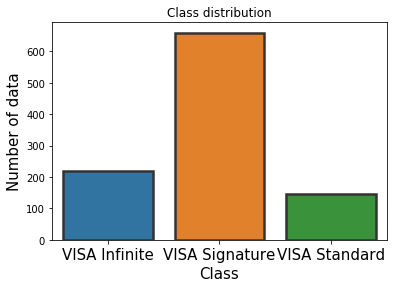

In [28]:
index = np.arange(len(class_name))
# plt.bar(class_name, count)
sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show(8, 4)

### Model building

In [29]:
# Checking class balance for Personal Loan:
train['type_y'].value_counts()

VISA Signature    659
VISA Infinite     220
VISA Standard     145
Name: type_y, dtype: int64

In [30]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder

In [31]:
# create a list of categorical columns to iterate over
cat_cols=[]
for i in train.columns:
    if train[i].dtype == 'object':
        cat_cols.append(i)
    else:
        continue

In [32]:
encoder = OrdinalEncoder()
imputer = IterativeImputer(ExtraTreesRegressor())

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

In [33]:
df_to_encode=[train,test_other]

In [34]:
#create a for loop to iterate through each column in the data
for i in df_to_encode:
    for columns in cat_cols:
        encode(i[columns])

C:\Users\Upas\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Upas\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Upas\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [35]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

In [36]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:60].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(12, 14))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')

In [37]:
X = train.iloc[:,:-1].values
Y = train.iloc[:,-1:].values

print('X.shape = ' + str(X.shape))
print('Y.shape = ' + str(Y.shape))
params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mse',
        'max_depth': 8, 
        'learning_rate': 0.02,
        'verbose': 0, 
        'early_stopping_round': 20,
        'num_leaves':34,
        'colsample_bytree':0.9497036,
        'subsample':0.8715623,
        'n_estimators':1000}
    

feature_importance_df = pd.DataFrame()
folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, Y)):
    train_x, train_y = X[train_idx], Y[train_idx].ravel()
    valid_x, valid_y = X[valid_idx], Y[valid_idx].ravel()

    # LightGBM parameters found by Bayesian optimization

    gbm = lgb.LGBMRegressor(**params)


    #  LightGBM parameters found by Bayesian optimization
    print('Training and making predictions')
    print(type(train_x))
    gbm.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric= 'l1', verbose= 100, early_stopping_rounds= 200)
    y_pred = gbm.predict(train_x, num_iteration=gbm.best_iteration_)
    # Basic RMSE
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train.iloc[:,:-1].columns
    fold_importance_df["importance"] = gbm.feature_importances_
    print(fold_importance_df.head())   
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d rmse : %.6f' % (n_fold + 1, round(mean_squared_error(y_pred, train_y) ** 0.5, 5)))
#     del gbm, train_x, train_y, valid_x, valid_y



X.shape = (1024, 23)
Y.shape = (1024, 1)
Training and making predictions
<class 'numpy.ndarray'>


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.178717	training's l2: 0.0722258	valid_1's l1: 0.191099	valid_1's l2: 0.087168
Early stopping, best iteration is:
[135]	training's l1: 0.154479	training's l2: 0.0598108	valid_1's l1: 0.178241	valid_1's l2: 0.0850909
     feature  importance
0  client_id         260
1        sex          20
2        age         567
3     city_x         183
4      state         163
Fold  1 rmse : 0.244560
Training and making predictions
<class 'numpy.ndarray'>
Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.1848	training's l2: 0.077469	valid_1's l1: 0.175956	valid_1's l2: 0.0733073

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Early stopping, best iteration is:
[155]	training's l1: 0.151835	training's l2: 0.059261	valid_1's l1: 0.158847	valid_1's l2: 0.0691793
     feature  importance
0  client_id         429
1        sex          36
2        age         722
3     city_x         173
4      state         155
Fold  2 rmse : 0.243440
Training and making predictions
<class 'numpy.ndarray'>
Training until validation scores don't improve for 20 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's l1: 0.17677	training's l2: 0.0749966	valid_1's l1: 0.233067	valid_1's l2: 0.128942
Early stopping, best iteration is:
[171]	training's l1: 0.141456	training's l2: 0.0555976	valid_1's l1: 0.217263	valid_1's l2: 0.121554
     feature  importance
0  client_id         429
1        sex          87
2        age         703
3     city_x         133
4      state         231
Fold  3 rmse : 0.235790
Training and making predictions
<class 'numpy.ndarray'>
Training until validation scores don't improve for 20 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's l1: 0.167485	training's l2: 0.0645899	valid_1's l1: 0.226462	valid_1's l2: 0.12674
Early stopping, best iteration is:
[106]	training's l1: 0.162425	training's l2: 0.0621785	valid_1's l1: 0.223482	valid_1's l2: 0.126376
     feature  importance
0  client_id         226
1        sex          19
2        age         449
3     city_x          75
4      state         132
Fold  4 rmse : 0.249360
Training and making predictions
<class 'numpy.ndarray'>
Training until validation scores don't improve for 20 rounds


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's l1: 0.169158	training's l2: 0.0683051	valid_1's l1: 0.221344	valid_1's l2: 0.118181
Early stopping, best iteration is:
[125]	training's l1: 0.150437	training's l2: 0.0588396	valid_1's l1: 0.211604	valid_1's l2: 0.117016
     feature  importance
0  client_id         242
1        sex          20
2        age         482
3     city_x         104
4      state         155
Fold  5 rmse : 0.242570


### Feature importance

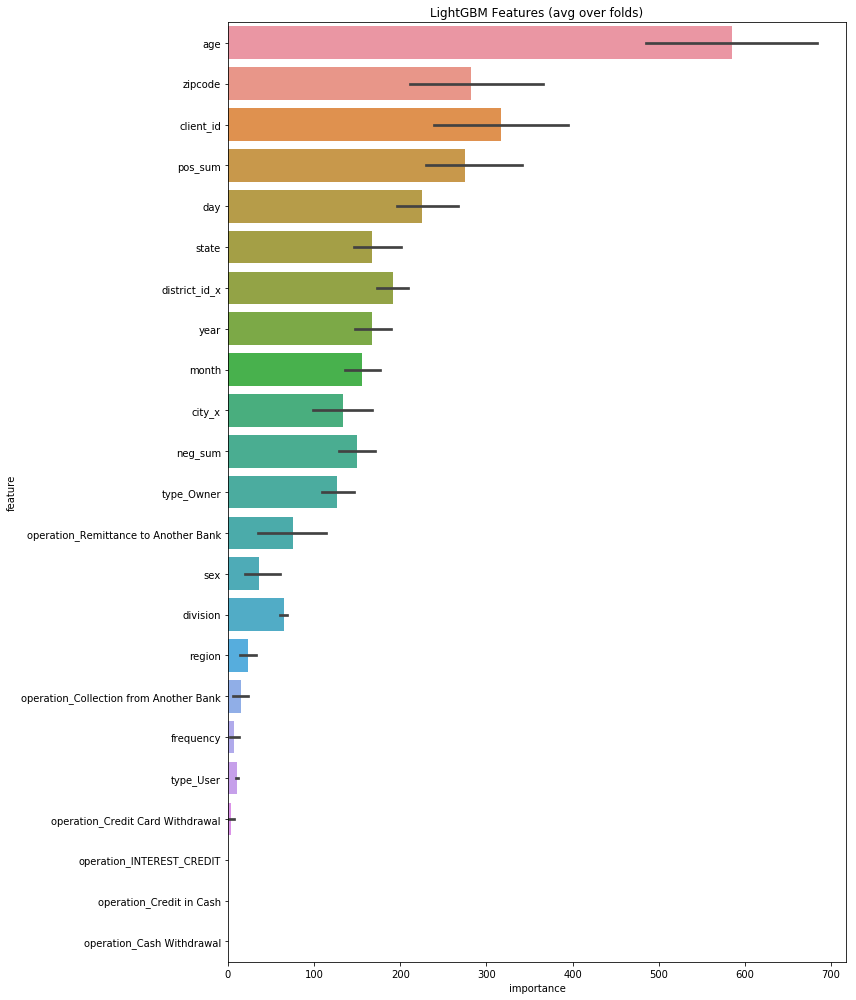

In [38]:
display_importances(feature_importance_df)

In [39]:

feature =['client_id','sex', 'age', 'city_x', 'state', 'zipcode', 'district_id_x','month', 'pos_sum', 'neg_sum','type_Owner','type_y'
         , 'operation_Collection from Another Bank','operation_Credit Card Withdrawal', 'operation_Remittance to Another Bank','region','division']

In [40]:
train =train[feature]

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
train1, test = train_test_split(train, test_size=0.2, random_state=0)

In [43]:
X_train = pd.DataFrame(train1.drop(['type_y'],axis=1))
Y_train = train1.type_y.values
X_test = pd.DataFrame(test.drop(['type_y'],axis=1))
Y_test = test.type_y.values

### Radom forest Classifier with StratifiedKFold CV & ensemble

In [44]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}".format(i, j, recall, f1))
            
        return train_pred, test_pred, recall_scores, f1_scores

In [45]:
## Sklearn Libraries
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve

import warnings
# Define random state
random_state = 2018
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = random_state)


In [47]:
rdf = RandomForestClassifier(random_state = random_state) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {'max_depth': [6, 8, 10, 20], 
              'min_samples_split': [5, 10, 15],
              'min_samples_leaf' : [4, 8, 12],
              'n_estimators' : [300, 400, 500]
             }

grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(X_train, Y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  5.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2018, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                          

In [48]:

print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=2018,
                       verbose=0, warm_start=False)
{'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 400}


In [49]:
rdf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False,
            random_state=random_state,
            verbose=0, warm_start=False)

In [50]:
base_models = [rdf]
n_splits = 5
lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)        


In [51]:
xtrain = train.drop(['type_y'], axis=1)
ytrain = train['type_y'].values
ytest=test.drop(['type_y'], axis=1)

In [52]:
train_pred, test_pred, recall_scores, f1_scores = lgb_stack.predict(xtrain, ytrain, ytest)


Model- 0 and CV- 0 recall: 0.8392546151166841, f1_score: 0.8593849078790475
Model- 0 and CV- 1 recall: 0.8288923719958202, f1_score: 0.8765861300308094
Model- 0 and CV- 2 recall: 0.8215778474399165, f1_score: 0.8514341613387835
Model- 0 and CV- 3 recall: 0.8025078369905957, f1_score: 0.8327891413539402
Model- 0 and CV- 4 recall: 0.7719435736677115, f1_score: 0.8259189810860522


In [54]:
print('1. The F-1 score of the model {}\n'.format(f1_score(ytrain, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(ytrain, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(ytrain, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(ytrain, train_pred)))

1. The F-1 score of the model 0.8494877792169143

2. The recall score of the model 0.8128268187605742

3. Classification report 
               precision    recall  f1-score   support

         0.0       1.00      0.60      0.75       220
         1.0       0.86      0.98      0.92       659
         2.0       0.91      0.86      0.88       145

    accuracy                           0.88      1024
   macro avg       0.92      0.81      0.85      1024
weighted avg       0.90      0.88      0.88      1024
 

4. Confusion matrix 
 [[132  87   1]
 [  0 648  11]
 [  0  21 124]] 



In [57]:
class_names=['VISA Signature','VISA Infinite','VISA Standard']

NameError: name 'train_proba' is not defined

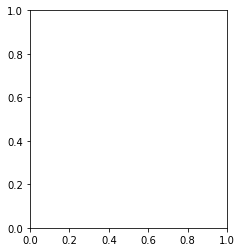

In [55]:
plt.figure(figsize=(12, 4))
nclasses = 3
for i in range(nclasses):
    
    plt.subplot(1, 3, i+1)
    plt.hist(train_proba[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('Predicted class-{} probabilities'.format(i+1))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Due to the unbalance data, the probabilities for minor classes (class-0 ) are inaccurate.

Predict probabilities instead of actual prediction.
Set the class weight.
Get probability distribution of minor class.
From the ROC curve and probability distribution obtain probability thresholds for classes.
Finally use the threshold to over-predict a label than under-predict.

In [326]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        no_class = len(np.unique(y))

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_proba = np.zeros((X.shape[0], no_class))
        test_proba = np.zeros((T.shape[0], no_class))
        
        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                ## Probabilities
                valid_proba = clf.predict_proba(X_valid)
                train_proba[valid_idx, :] = valid_proba
                test_proba  += clf.predict_proba(T)
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}".format(i, j, recall, f1))
                
            test_proba /= self.n_splits
            
        return train_proba, test_proba, train_pred, test_pred

In [327]:
from sklearn.ensemble import RandomForestClassifier
class_weight = dict({0:154,1:18, 2:14})

rdf = RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False,
            random_state=random_state,
            verbose=0, warm_start=False)

In [328]:
base_models = [rdf]
n_splits = 5
lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)        

xtrain = train.drop(['type_y'], axis=1)
ytrain = train['type_y'].values
# ytrain = label_binarize(Y, classes=[0, 1, 2])

In [329]:
xtest =test.drop(['type_y'], axis=1)

In [330]:
train_proba, test_proba, train_pred, test_pred = lgb_stack.predict(xtrain, ytrain, xtest)


Model- 0 and CV- 0 recall: 0.8126088470916057, f1_score: 0.8264476988100252
Model- 0 and CV- 1 recall: 0.807297109021247, f1_score: 0.8359333476980536
Model- 0 and CV- 2 recall: 0.79858934169279, f1_score: 0.8294409166253119
Model- 0 and CV- 3 recall: 0.7924068268895855, f1_score: 0.8082221227048813
Model- 0 and CV- 4 recall: 0.7616497961983617, f1_score: 0.7970576621355764


In [331]:
print('1. The F-1 score of the model {}\n'.format(f1_score(ytrain, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(ytrain, train_pred, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(ytrain, train_pred)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(ytrain, train_pred)))

1. The F-1 score of the model 0.8196010720295396

2. The recall score of the model 0.7945083190229965

3. Classification report 
               precision    recall  f1-score   support

         0.0       0.74      0.64      0.68       220
         1.0       0.85      0.92      0.89       659
         2.0       0.96      0.83      0.89       145

    accuracy                           0.85      1024
   macro avg       0.85      0.79      0.82      1024
weighted avg       0.84      0.85      0.84      1024
 

4. Confusion matrix 
 [[140  79   1]
 [ 49 606   4]
 [  0  25 120]] 



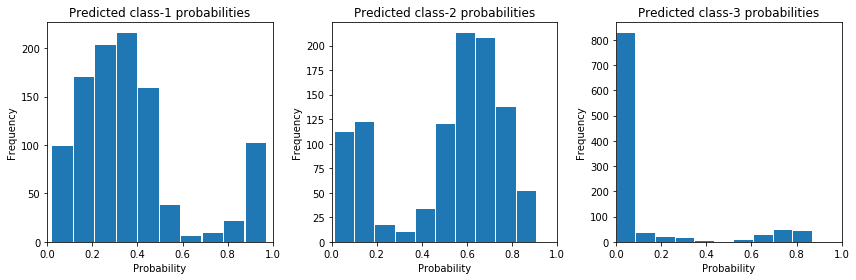

In [332]:
plt.figure(figsize=(12, 4))
nclasses = 3
for i in range(nclasses):
    
    plt.subplot(1, 3, i+1)
    plt.hist(train_proba[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('Predicted class-{} probabilities'.format(i+1))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [333]:
test_other=test_other[feature]

In [334]:
xtest1 =test_other.drop(['type_y'], axis=1)

In [335]:
train_proba, test_proba, train_pred, test_pred = lgb_stack.predict(xtrain, ytrain, xtest1)


Model- 0 and CV- 0 recall: 0.8126088470916057, f1_score: 0.8264476988100252
Model- 0 and CV- 1 recall: 0.807297109021247, f1_score: 0.8359333476980536
Model- 0 and CV- 2 recall: 0.79858934169279, f1_score: 0.8294409166253119
Model- 0 and CV- 3 recall: 0.7924068268895855, f1_score: 0.8082221227048813
Model- 0 and CV- 4 recall: 0.7616497961983617, f1_score: 0.7970576621355764


In [336]:
tpred = pd.DataFrame(test_pred)
tpred

,0,1,2,3,4
0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
4340,1.0,1.0,1.0,1.0,1.0
4341,1.0,1.0,1.0,1.0,1.0
4342,0.0,0.0,0.0,0.0,0.0
4343,1.0,1.0,1.0,1.0,1.0


In [337]:
final_tpred = tpred.mode(axis=1)

In [338]:
final_tpred[0].value_counts()

1.0    3386
0.0     741
2.0     218
Name: 0, dtype: int64

#### Decision Tree Classification Model

In [223]:
# Decision Tree Model Prediction
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()

In [224]:
train1, test = train_test_split(train, test_size=0.2, random_state=0)

In [225]:
X_train = pd.DataFrame(train1.drop(['type_y'],axis=1))
Y_train = train1.type_y.values
X_test = pd.DataFrame(test.drop(['type_y'],axis=1))
Y_test = test.type_y.values

In [226]:
dt.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [227]:
y_pred_base=dt.predict(X_test)

In [228]:
# Finding Accuracy:
from sklearn.metrics import accuracy_score
acc=accuracy_score(Y_test,y_pred_base)
print(acc)

0.7951219512195122


In [229]:
# Model validation:
from sklearn.metrics import confusion_matrix,classification_report
confusion_matrix(Y_test,y_pred_base)

array([[ 30,  20,   0],
       [ 16, 112,   4],
       [  0,   2,  21]], dtype=int64)

**Accuracy**: (TP+TN)/(TP+TN+FP+FN)

**Classification Error**: (FP+FN)/(TP+TN+FP+FN) or 1-Accuracy

**Sensitivity**: When the actual value is positive, how often is the prediction correct. TP/FN+TP

**Specificity**: When the actual value is neagative, how often is the prediction correct. TN/TN+FP

**Precision**: When the positive value is predicted, how often is the prediction correct. TP/TP+FP

In [230]:
#Classification Report:
clf_report=classification_report(Y_test,y_pred_base)
print(clf_report)

              precision    recall  f1-score   support

         0.0       0.65      0.60      0.63        50
         1.0       0.84      0.85      0.84       132
         2.0       0.84      0.91      0.87        23

    accuracy                           0.80       205
   macro avg       0.78      0.79      0.78       205
weighted avg       0.79      0.80      0.79       205



In [231]:
# Hyper Parameter Tuning:
from sklearn.model_selection import GridSearchCV
parameters={'criterion':['gini','entropy'],'max_depth':np.arange(1,50),'min_samples_leaf':[1,2,3,6,9,4]}
grid=GridSearchCV(dt,parameters)

In [232]:
model=grid.fit(X_train,Y_train)

In [233]:
grid.best_score_

0.8986233727367949

In [234]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1}

In [235]:
clf_best=grid.best_estimator_

In [236]:
clf_best.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [237]:
y_pred_best=clf_best.predict(X_test)

In [238]:
accuracy_score(Y_test,y_pred_best)

0.8536585365853658

In [239]:
from sklearn.model_selection import cross_val_score

In [240]:
x=train.drop(['type_y'],axis=1)
y=train['type_y']

In [241]:
cross_val=cross_val_score(clf_best,x,y,cv=10)
print(cross_val)

[0.93203883 0.88349515 0.82524272 0.87378641 0.90196078 0.85294118
 0.89215686 0.93137255 0.85294118 0.89215686]


In [242]:
np.mean(cross_val)

0.8838092518560823

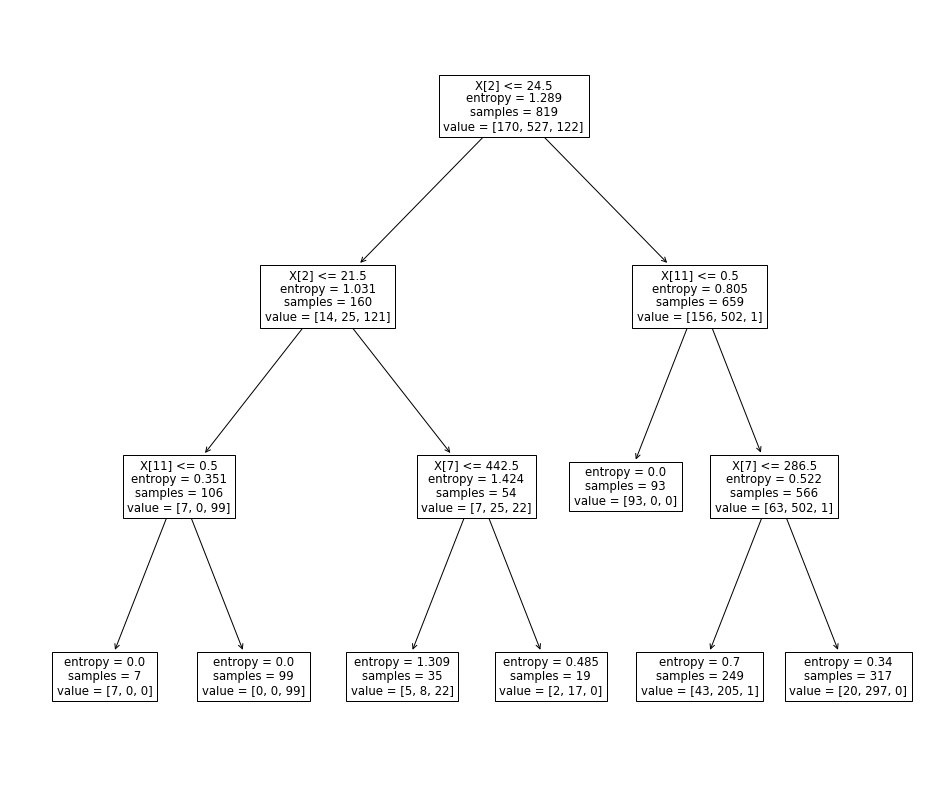

In [243]:
# Visualizg the Tree:
from sklearn import tree
plt.figure(figsize=(16,14))
tree.plot_tree(clf_best)
plt.show()

In [ ]:
#final_tpred.to_csv('predicted_labels.csv', index=False, header= False)


###  Lime feature explanation with h2o

In [63]:
import lime
import lime.lime_tabular

In [64]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator


**Wrapper Class**--
We need a wrapper class that makes an H2O distributed random forest behave like a scikit learn random forest. We instantiate the class with an h2o distributed random forest object and column names. The predict_proba method takes a numpy array as input and returns an array of predicted probabilities for each class.

In [65]:
class h2o_predict_proba_wrapper:
    # drf is the h2o distributed random forest object, the column_names is the
    # labels of the X values
    def __init__(self,model,column_names):
            
            self.model = model
            self.column_names = column_names
 
    def predict_proba(self,this_array):        
        # If we have just 1 row of data we need to reshape it
        shape_tuple = np.shape(this_array)        
        if len(shape_tuple) == 1:
            this_array = this_array.reshape(1, -1)
            
        # We convert the numpy array that Lime sends to a pandas dataframe and
        # convert the pandas dataframe to an h2o frame
        self.pandas_df = pd.DataFrame(data = this_array,columns = self.column_names)
        self.h2o_df = h2o.H2OFrame(self.pandas_df)
        
        # Predict with the h2o drf
        self.predictions = self.model.predict(self.h2o_df).as_data_frame()
        # the first column is the class labels, the rest are probabilities for
        # each class
        self.predictions = self.predictions.iloc[:,1:].to_numpy()
        return self.predictions

In [66]:
class_labels = 'type_y'

In [91]:
feature_names =['client_id',
 'sex',
 'age',
 'city_x',
 'state',
 'zipcode',
 'district_id_x',
 'month',
 'pos_sum',
 'neg_sum',
 'type_Owner',
 'operation_Collection from Another Bank',
 'operation_Credit Card Withdrawal',
 'operation_Remittance to Another Bank',
 'region',
 'division']

In [92]:
import sklearn
import sklearn.datasets
import sklearn.ensemble

In [93]:
h2o.init() 

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,8 mins 04 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_Upas_3xh4ia
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,989 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [94]:
X_train =train

In [95]:
labels=X_train['type_y'].to_list()

In [96]:
# Generate a train test split and convert to pandas and h2o frames

train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X_train[feature_names], labels, train_size=0.80)

train_h2o_df = h2o.H2OFrame(train)
train_h2o_df.set_names(feature_names)
train_h2o_df['type_y'] = h2o.H2OFrame(labels_train)
train_h2o_df['type_y'] = train_h2o_df['type_y'].asfactor()

test_h2o_df = h2o.H2OFrame(test)
test_h2o_df.set_names(feature_names)
test_h2o_df['type_y'] = h2o.H2OFrame(labels_test)
test_h2o_df['type_y'] = test_h2o_df['type_y'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [97]:
# rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
# rf.fit(train, labels_train)

credit_drf = H2ORandomForestEstimator(
        model_id="credit_drf",
        ntrees=300,
        stopping_rounds=2,
        score_each_iteration=True,
        seed=1000,
        balance_classes=False,
        histogram_type="AUTO")

credit_drf.train(x=feature_names,
         y='type_y',
         training_frame=train_h2o_df)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [98]:
# sklearn.metrics.accuracy_score(labels_test, rf.predict(test))

credit_drf.model_performance(test_h2o_df)


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.11929348393492624
RMSE: 0.3453888879725667
LogLoss: 0.42002086455962967
Mean Per-Class Error: 0.23633633633633636

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,Error,Rate
0,14.0,14.0,0.0,0.500000,14 / 28
1,0.0,110.0,1.0,0.009009,1 / 111
2,1.0,4.0,20.0,0.200000,5 / 25
3,15.0,128.0,21.0,0.121951,20 / 164



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.878049
1,2,0.987805
2,3,1.000000


**Convert h2o to numpy array**
The explainer requires numpy arrays as input and h2o requires the train and test data to be in h2o frames. In this case we could just use the train and test numpy arrays but for illustrative purposes here is how to convert an h2o frame to a pandas dataframe and a pandas dataframe to a numpy array.

In [154]:
train_pandas_df = train_h2o_df[feature_names].as_data_frame() 
train_numpy_array = train_pandas_df.to_numpy()

test_pandas_df = test_h2o_df[feature_names].as_data_frame() 
test_numpy_array = test_pandas_df.to_numpy()

In [155]:
test_numpy_array

array([[639.,   0.,  56., ...,   1.,   1.,   4.],
       [898.,   1.,  63., ...,   1.,   1.,   2.],
       [442.,   1.,  58., ...,   1.,   1.,   4.],
       ...,
       [  8.,   0.,  32., ...,   1.,   1.,   4.],
       [294.,   0.,  35., ...,   1.,   3.,   5.],
       [509.,   0.,  58., ...,   1.,   3.,   3.]])

### Create the explainer
As opposed to lime_text.TextExplainer, tabular explainers need a training set. The reason for this is because we compute statistics on each feature (column). If the feature is numerical, we compute the mean and std, and discretize it into quartiles. If the feature is categorical, we compute the frequency of each value. For this tutorial, we'll only look at numerical features.

##### We use these computed statistics for two things:

To scale the data, so that we can meaningfully compute distances when the attributes are not on the same scale
To sample perturbed instances - which we do by sampling from a Normal(0,1), multiplying by the std and adding back the mean.


In [156]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_numpy_array,
                                                   feature_names=feature_names,
                                                   class_names=labels_train,
                                                   discretize_continuous=True)

#### Create the predictor wrapper instance for the h2o drf
We have a trained h2o distributed random forest that we would like to explain. We need to create a wrapper instance that will make it behave as a scikit learn random forest for our Lime explainer.

In [157]:
h2o_drf_wrapper = h2o_predict_proba_wrapper(credit_drf,feature_names) 


#### Explaining an instance
Since this is a multi-class classification problem, we set the top_labels parameter, so that we only explain the top class.

In [159]:
i = 27
# exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=2, top_labels=1)

exp = explainer.explain_instance(test_numpy_array[i], h2o_drf_wrapper.predict_proba, num_features=3, top_labels=3)

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


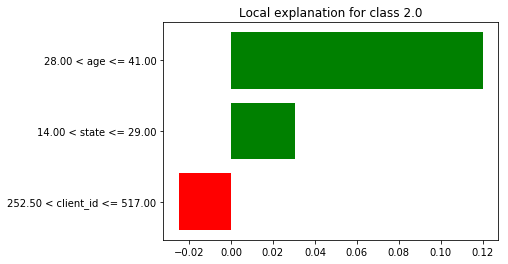

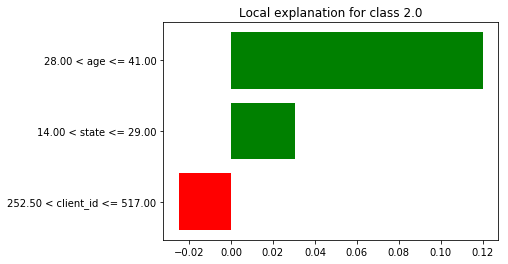

In [160]:
display(exp.as_pyplot_figure())

In [124]:
i = 120

exp = explainer.explain_instance(test_numpy_array[i], h2o_drf_wrapper.predict_proba, num_features=10, top_labels=3)

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


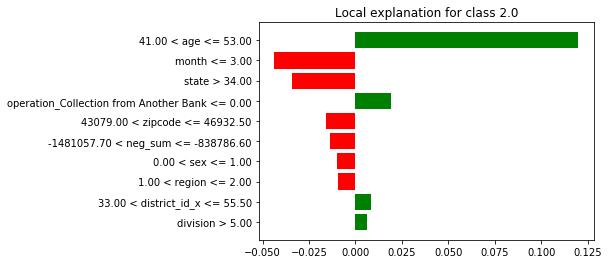

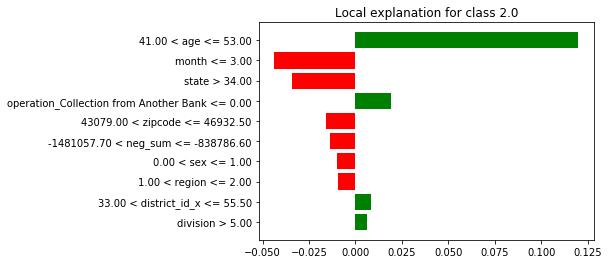

In [126]:
display(exp.as_pyplot_figure())

In [129]:
i = 50

exp = explainer.explain_instance(test_numpy_array[i], h2o_drf_wrapper.predict_proba, num_features=10, top_labels=1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


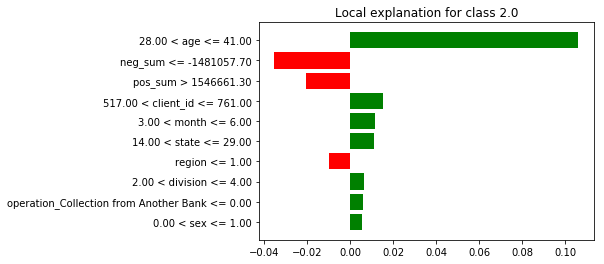

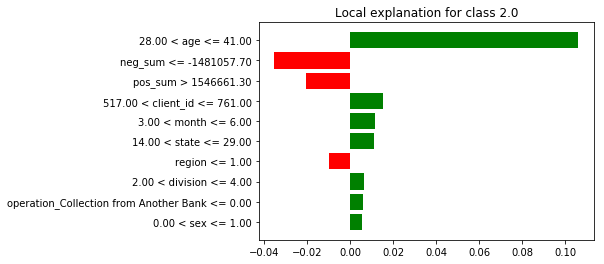

In [130]:
display(exp.as_pyplot_figure())

In [161]:
exp.as_list()


[('28.00 < age <= 41.00', 0.12003326459746706),
 ('14.00 < state <= 29.00', 0.030330906425831777),
 ('252.50 < client_id <= 517.00', -0.024945343768470286)]

In [164]:
exp.save_to_file('lime.html')

Now, there is a lot going on here. First, note that the row we are explained is displayed on the right side, in table format. Since we had the show_all parameter set to false, only the features used in the explanation are displayed.

The value column displays the original value for each feature.

Note that LIME has discretized the features in the explanation. This is because we let discretize_continuous=True in the constructor (this is the default). Discretized features make for more intuitive explanations.

In [206]:
h2o.remove_all()

In [ ]:
h2o.shutdown(prompt=False)